<a href="https://colab.research.google.com/github/jocelynbaduria/cmpe-257_Machine_Learning/blob/main/Jocelyn_Baduria_Politifact_FoxNews_cmpe_257_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install necessary Libraries to run the notebook. Mounting drive is done automatically once login to your google drive.

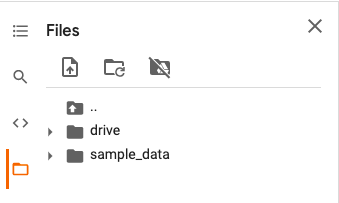

In [ ]:
# !pip install requests beautifulsoup4 
# !pip install sidetable
!pip install sidetable -U
!pip install pandas -U  
!pip install nltk
!pip install gensim
!pip install textract

     |████████████████████████████████| 9.9MB 14.2MB/s 
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5


     |████████████████████████████████| 5.6MB 14.2MB/s 
     |████████████████████████████████| 112kB 42.7MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 32.8MB 131kB/s 
     |████████████████████████████████| 112kB 54.8MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 8.9MB 43.3MB/s 
     |████████████████████████████████| 1.9MB 44.8MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 112kB 51.1MB/s 
     |████████████████████████████████| 153kB 51.8MB/s 
  Created wheel for docx2txt: filename=docx2txt-0.8-cp37-none-any.whl size=3963 sha256=e8adbc1a41f750c680289f16a014c36d506c914c29607d4e6fea88958b3617b6
  Stored in directory: /root/.cache/pip/wheels/b2/1f/26/a051209bbb77fc6bcfae2bb7e01fa0ff941b82292ab084d596
  Created wheel for EbookLib: filename=EbookLib-0.17.1-cp37-none-any.whl size=38165 sha256=21163062e762dd6f47f71e806f9905438829c0

In [ ]:
from bs4 import BeautifulSoup 
import pandas as pd
import requests
import urllib.request
import time
import re
import sidetable
import gensim
from textract import process

import nltk
nltk.download('stopwords')
%matplotlib inline

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Factor: Source Reputation

Microfactors
1. Url ( news article )
2. Article count, publish date
3. Wrting Style ( Sentence Similarity )

## Visualization

In [ ]:
# Politifact
import pandas as pd
path = '/content/drive/MyDrive/cmpe-257 Machine Leaning/scraped_data/saved_csv/political_fact_checker_2000.csv'
data_politifact = pd.read_csv(path, parse_dates=True)

In [ ]:
# Fox News
import pandas as pd
path = '/content/drive/MyDrive/cmpe-257 Machine Leaning/scraped_data/saved_csv/foxnews_2000.csv'
data_foxnews = pd.read_csv(path, parse_dates=True)

### Factor - Reliable Source
Microfactors (1. news article - (politifact, foxnews), 2. persona credibility - source count and published date, and 3. writing style - Naive Base Classifier and Cosine Text Similarity)

Data Narrative : 

In [ ]:
data_politifact

,author,date,statement,source,date_published,target
0,Tom Kertscher,"March 30, 2021",“Less than 500 people a year killed by all rif...,Facebook posts,"March 21, 2021",barely-true
1,Tom Kertscher,"March 30, 2021",Says the suspected Boulder mass shooter is a M...,Facebook posts,"March 24, 2021",barely-true
2,Bill McCarthy,"March 30, 2021",“Toxicology report was made public by the MN p...,Facebook posts,"March 24, 2021",false
3,Gabrielle Settles,"March 30, 2021","Says Jimmy Kimmel, Jimmy Fallon and Stephen Co...",Facebook posts,"March 25, 2021",false
4,Samantha Putterman,"March 29, 2021",Says Google Earth blocked people from seeing t...,Facebook posts,"March 28, 2021",false
...,...,...,...,...,...,...
59965,Ciara O'Rourke,"March 25, 2021",Passports aren’t required to enter the United ...,Facebook posts,"March 20, 2021",barely-true
59966,Daniel Funke,"March 25, 2021","""Suez Canal blocked by huge container ship nam...",Facebook posts,"March 24, 2021",pants-fire
59967,Duncan Slade,"March 25, 2021",West Virginia “is the only state to decline in...,Jim Justice,"March 4, 2021",true
59968,Bill McCarthy,"March 25, 2021",A CNN chyron said the Boulder “shooter was fac...,Facebook posts,"March 24, 2021",pants-fire


In [ ]:
data_foxnews

,date,headline
0,2021-04-18,Wisconsin police arrest suspect wanted for dea...
1,2021-04-18,WATCH: County officials ignore mother pleading...
2,2021-04-18,Grocery chain closes two stores in city that r...
3,2021-04-18,Insider ripped for piece victimizing teachers ...
4,2021-04-18,Photo catches Queen in rare moment of emotion ...
...,...,...
331995,2021-04-18,Minnesota armed carjacker points gun at vehicl...
331996,2021-04-18,Houston police say crystal meth found in break...
331997,2021-04-18,Minneapolis drive-by shooting leaves 2 Nationa...
331998,2021-04-18,Man charged with attacking undercover NYPD cop...


### Politifact Visualization

In [ ]:
import plotly.express as px
fig = px.histogram(data_politifact, x='target',y='source', color="source",
                   marginal="violin", # or violin, rug
                   hover_data=data_politifact.columns, width=1000, height=600, title="Fact Checked vs Publisher ")
fig.show()

In [ ]:
import plotly.express as px
fig = px.histogram(data_politifact, x='source',y='target', color="target",
                   marginal="violin", # or violin, rug
                   hover_data=data_politifact.columns, width=1000, height=600, title="Publisher vs Fact Checked")
fig.show()

In [ ]:
import plotly.express as px
fig = px.histogram(data_politifact, x='date',y='statement', color="date",
                   hover_data=data_politifact.columns, width=1000, height=600, title="Politifact Published date vs Headline Counts ")
fig.show()

Politifact Table - Cumulative Count and Percent

In [ ]:
import sidetable
data_politifact.stb.freq(['target'])

,target,count,percent,cumulative_count,cumulative_percent
0,barely-true,17991,30.000000,17991,30.000000
1,false,15992,26.666667,33983,56.666667
2,half-true,9995,16.666667,43978,73.333333
3,pants-fire,5997,10.000000,49975,83.333333
4,mostly-true,5997,10.000000,55972,93.333333
5,true,3998,6.666667,59970,100.000000


In [ ]:
import sidetable
data_politifact.stb.freq(['source'])

,source,count,percent,cumulative_count,cumulative_percent
0,Facebook posts,23988,40.000000,23988,40.000000
1,Joe Biden,3998,6.666667,27986,46.666667
2,Viral image,1999,3.333333,29985,50.000000
3,Veronica Escobar,1999,3.333333,31984,53.333333
4,Tweets,1999,3.333333,33983,56.666667
5,Tony Evers,1999,3.333333,35982,60.000000
6,Rand Paul,1999,3.333333,37981,63.333333
7,Kirsten Gillibrand,1999,3.333333,39980,66.666667
8,Julian Bradley,1999,3.333333,41979,70.000000
9,Joy Behar,1999,3.333333,43978,73.333333


In [ ]:
import sidetable
data_politifact.stb.freq(['statement'])

,statement,count,percent,cumulative_count,cumulative_percent
0,“You can’t tell me they can (develop a safe va...,1999,3.333333,1999,3.333333
1,“We’re sending back the vast majority of the f...,1999,3.333333,3998,6.666667
2,“We spent billions on a border wall and quit w...,1999,3.333333,5997,10.000000
3,“We had the highest number of (military) sexua...,1999,3.333333,7996,13.333333
4,“Toxicology report was made public by the MN p...,1999,3.333333,9995,16.666667
5,“There’s still (only) a handful of school dist...,1999,3.333333,11994,20.000000
6,"“Sorry Dr Fauci and other fearmongers, new stu...",1999,3.333333,13993,23.333333
7,“Republicans recently passed a bill to elimina...,1999,3.333333,15992,26.666667
8,“Less than 500 people a year killed by all rif...,1999,3.333333,17991,30.000000
9,“In a vegan world there would be no pandemics....,1999,3.333333,19990,33.333333


In [ ]:
# Unique target 
statement_sorted = data_politifact['target'].unique()
statement_sorted.sort()
print(statement_sorted)

['barely-true' 'false' 'half-true' 'mostly-true' 'pants-fire' 'true']


### FoxNews Visualization

In [ ]:
import plotly.express as px
fig = px.histogram(data_foxnews, x='date',y='headline', color="date",
                   hover_data=data_foxnews.columns, width=1000, height=600, title="Fox News Published date vs Headline Counts ")
fig.show()

## Politifact NLP Modeling - CountVectorizer, Tf-Idf and Naive Bayes Classifier
Data Narrative :

Training Text Data using Politifact headlines got an accuracy of 100%.

Train the Politifact text

In [ ]:
from sklearn.model_selection import train_test_split
X = data_politifact['statement']
y = data_politifact['statement']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

### CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
count_vect = CountVectorizer()

In [ ]:
X_politifact_train = count_vect.fit_transform(data_politifact['statement'])

In [ ]:
y_politifact_train = count_vect.fit_transform(data_politifact['statement'])

In [ ]:
y = data_politifact.iloc[1:10, [2]].values
print(y)

[['Says the suspected Boulder mass shooter is a Muslim "who entered illegally from Mexico and purchased the firearm from a guy that sells stolen guns."']
 ['“Toxicology report was made public by the MN prosecution revealing the cause of George Floyd’s death was a fentanyl overdose.”']
 ['Says Jimmy Kimmel, Jimmy Fallon and Stephen Colbert are “still not doing Biden jokes."']
 ['Says Google Earth blocked people from seeing the Suez Canal.']
 ['“We spent billions on a border wall and quit when it was 90% finished.”']
 ['A Georgia law has not “criminalized giving people bottles of water.” It pertains to political organizations.']
 ['"There are 43 states that have now passed voter suppression laws."']
 ['"Joe Biden forced the U.S. Attorney for the Eastern District of North Carolina to resign after 24 people were charged with election fraud and the Mainstream Media never even batted an eyelash."']
 ['Nike and Lil Nas X are launching “demonic shoes” containing human blood.']]


In [ ]:
# y_politifact_train = data_politifact.iloc[0:1000, [2]].values

In [ ]:
X_politifact_train.shape

(59970, 349)

In [ ]:
y_politifact_train.shape

(59970, 349)

In [ ]:
count_vect.vocabulary_.get(u'algorithm')

In [ ]:
# count_vect.vocabulary_.get(u'algorithm')
print(count_vect.vocabulary_)

{'less': 173, 'than': 305, '500': 18, 'people': 232, 'year': 345, 'killed': 166, 'by': 58, 'all': 26, 'rifles': 263, 'combined': 76, 'and': 28, '000': 0, 'illegals': 152, 'says': 267, 'the': 307, 'suspected': 298, 'boulder': 54, 'mass': 184, 'shooter': 279, 'is': 160, 'muslim': 200, 'who': 340, 'entered': 108, 'illegally': 151, 'from': 129, 'mexico': 188, 'purchased': 243, 'firearm': 122, 'guy': 138, 'that': 306, 'sells': 270, 'stolen': 292, 'guns': 137, 'toxicology': 316, 'report': 254, 'was': 332, 'made': 180, 'public': 242, 'mn': 193, 'prosecution': 241, 'revealing': 261, 'cause': 65, 'of': 215, 'george': 130, 'floyd': 124, 'death': 86, 'fentanyl': 120, 'overdose': 224, 'jimmy': 163, 'kimmel': 167, 'fallon': 115, 'stephen': 289, 'colbert': 75, 'are': 32, 'still': 290, 'not': 211, 'doing': 96, 'biden': 47, 'jokes': 165, 'google': 135, 'earth': 100, 'blocked': 50, 'seeing': 269, 'suez': 295, 'canal': 61, 'we': 334, 'spent': 286, 'billions': 49, 'on': 216, 'border': 52, 'wall': 331, 'q

In [ ]:
# encode the whole document
vector_politifact = count_vect.transform(data_politifact['statement'])

In [ ]:
# summarize encoded vector
print(vector_politifact.shape)
print(type(vector_politifact))
print(vector_politifact.toarray())

(59970, 349)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Tf-Idf

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_politifact_train)
X_train_tfidf.shape

(59970, 349)

In [ ]:
print(X_train_tfidf)

  (0, 345)	0.34218670669346984
  (0, 305)	0.18741730403769205
  (0, 263)	0.21042322362368693
  (0, 232)	0.17109335334673492
  (0, 173)	0.249746000438621
  (0, 166)	0.499492000877242
  (0, 152)	0.249746000438621
  (0, 76)	0.249746000438621
  (0, 58)	0.3748346080753841
  (0, 28)	0.10000256270717497
  (0, 26)	0.249746000438621
  (0, 18)	0.249746000438621
  (0, 0)	0.249746000438621
  (1, 340)	0.23349474424960173
  (1, 307)	0.1796695175502441
  (1, 306)	0.14812180635442712
  (1, 298)	0.23349474424960173
  (1, 292)	0.23349474424960173
  (1, 279)	0.19673074522874962
  (1, 270)	0.23349474424960173
  (1, 267)	0.14812180635442712
  (1, 243)	0.23349474424960173
  (1, 200)	0.23349474424960173
  (1, 188)	0.19673074522874962
  (1, 184)	0.23349474424960173
  :	:
  (59969, 309)	0.15117469627321886
  (59969, 307)	0.23265178693854258
  (59969, 282)	0.25474415497565056
  (59969, 263)	0.12737207748782528
  (59969, 216)	0.10356516493210426
  (59969, 215)	0.06582815714103164
  (59969, 213)	0.127372077487825

### Naive Bayes Classifier Politifact

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, data_politifact['statement'])

In [ ]:
statement_new = ['Jimmy is my friend."']
X_new_counts = count_vect.transform(statement_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

In [ ]:
for doc, category in zip(statement_new, predicted):
  print('%r => %s' % (doc, predicted))

'Jimmy is my friend."' => ['Says Jimmy Kimmel, Jimmy Fallon and Stephen Colbert are “still not doing Biden jokes."']


### Pipeline Politifact

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [ ]:
text_clf.fit(X_train, y_train )

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
from sklearn import metrics
text_clf.fit(list(X_train), list(y_train))
predicted = text_clf.predict(list(X_test))
print(metrics.classification_report(list(y_test), predicted))

                                                                                                                                                                                                                               precision    recall  f1-score   support

"In 2004, George W. Bush lifted the ban on those (AR-15 type) rifles, and since then, the number of massacres has increased 183%. During the ban, there were 12 incidents. Since he lifted the ban, there were 34 incidents."       1.00      1.00      1.00       404
                            "Joe Biden forced the U.S. Attorney for the Eastern District of North Carolina to resign after 24 people were charged with election fraud and the Mainstream Media never even batted an eyelash."       1.00      1.00      1.00       387
                "Since 2006 Texas has given $19B in taxpayer subsidies to wind energy companies. Over the past 2-3 years Texas has tripled our dependence on wind energy to 23-25 percent of our energy distributi

In [ ]:
cf_matrix = confusion_matrix(X_test, y_test)

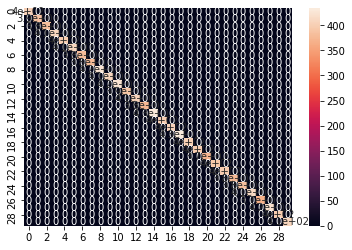

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
# plot_confusion_matrix(text_clf, X_test, y_test)

In [ ]:
roc_auc_score(y_test, text_clf.predict_proba(X_test), multi_class='ovr')

1.0

### Cosine Similarity - for verification the indexing method

In [ ]:
import gensim
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
politifact_corpus = []
for i in range(0, 2):
  review = re.sub('[^a-zA-Z]', ' ', data_politifact['statement'][i])
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  politifact_corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(politifact_corpus)

['less peopl year kill rifl combin year kill illeg', 'say suspect boulder mass shooter muslim enter illeg mexico purchas firearm guy sell stolen gun']


In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
gen_docs = [[w.lower() for w in word_tokenize(text)] 
  for text in politifact_corpus]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
dictionary = gensim.corpora.Dictionary(gen_docs)
print(dictionary.token2id)

{'combin': 0, 'illeg': 1, 'kill': 2, 'less': 3, 'peopl': 4, 'rifl': 5, 'year': 6, 'boulder': 7, 'enter': 8, 'firearm': 9, 'gun': 10, 'guy': 11, 'mass': 12, 'mexico': 13, 'muslim': 14, 'purchas': 15, 'say': 16, 'sell': 17, 'shooter': 18, 'stolen': 19, 'suspect': 20}


In [ ]:
# Convert to Bag of Words
politifact_corpus = [dictionary.doc2bow(gen_doc) for gen_doc in gen_docs]

In [ ]:
politifact_corpus

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 2)],
 [(1, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1)]]

In [ ]:
# Convert to tfidf >>> tfidf = models.TfidfModel(corpus)
tf_idf = gensim.models.TfidfModel(politifact_corpus)

In [ ]:
# Print the text frequency
import numpy as np
for doc in tf_idf[politifact_corpus]:
    print([[dictionary[id], np.around(freq, decimals=2)] for id, freq in doc])

[['combin', 0.29], ['kill', 0.58], ['less', 0.29], ['peopl', 0.29], ['rifl', 0.29], ['year', 0.58]]
[['boulder', 0.27], ['enter', 0.27], ['firearm', 0.27], ['gun', 0.27], ['guy', 0.27], ['mass', 0.27], ['mexico', 0.27], ['muslim', 0.27], ['purchas', 0.27], ['say', 0.27], ['sell', 0.27], ['shooter', 0.27], ['stolen', 0.27], ['suspect', 0.27]]


In [ ]:
# building the similarity index
# gensim.similarities.MatrixSimilarity corpus, num_best=None, dtype=<type 'numpy.float32'>, num_features=None, chunksize=256, corpus_len=None
index = gensim.similarities.Similarity('/content/drive/MyDrive/cmpe-257 Machine Leaning/HW/dir',tf_idf[politifact_corpus],num_features=len(dictionary))

In [ ]:
print(index)

Similarity index with 2 documents in 0 shards (stored under /content/drive/MyDrive/cmpe-257 Machine Leaning/HW/dir)


In [ ]:
import gensim
sims = index[tf_idf[politifact_corpus]]

In [ ]:
# The highest index with text similarity is 1.000001 the second document indexed.
print(sims)

[[0.99999994 0.        ]
 [0.         1.0000001 ]]


## Test the Politifact Trained model with text data from Fox News

Data Narrative : 

Accuracy score = 3%.

F1 score for each trained text samples range from 1% to 7% score.


Train Test Split 

In [ ]:
from sklearn.model_selection import train_test_split
X_train = data_politifact['statement']
y_train = data_politifact['statement']
X_test = data_foxnews['headline']
y_test = data_foxnews['headline']

max_r = 59970
X_test = X_test.iloc[0:max_r]
y_test = y_test.iloc[0:max_r]
# X = X_train + X_test
# y = y_train + y_test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

### CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
count_vect = CountVectorizer()

In [ ]:
X = count_vect.fit_transform(X_test)

In [ ]:
y = count_vect.fit_transform(y_test)

In [ ]:
y = data_foxnews.iloc[1:10, [1]].values
print(y)

[['WATCH: County officials ignore mother pleading for school reopening']
 ["Grocery chain closes two stores in city that required 'hero pay'"]
 ['Insider ripped for piece victimizing teachers during COVID']
 ["Photo catches Queen in rare moment of emotion at Prince Philip's funeral"]
 ['Portland church damaged in riot says cost of repairs will take away from feeding the homeless']
 ['Minneapolis drive-by shooting leaves 2 National Guard members injured']
 ['Deadly Texas crash involving Tesla worth $80,000 sparks four hour fire']
 ['Hundreds of migrant girls 13-17 abruptly moved out of Texas facility']
 ['Details emerge on how FedEx shooter obtained guns despite family concerns']]


In [ ]:
# y_politifact_train = data_politifact.iloc[0:1000, [2]].values

In [ ]:
X.shape

(59970, 1018)

In [ ]:
y.shape

(9, 1)

In [ ]:
count_vect.vocabulary_.get(u'algorithm')

In [ ]:
# count_vect.vocabulary_.get(u'algorithm')
print(count_vect.vocabulary_)

{'wisconsin': 996, 'police': 676, 'arrest': 64, 'suspect': 869, 'wanted': 967, 'for': 346, 'deadly': 244, 'shooting': 806, 'at': 74, 'kenosha': 496, 'lakeside': 508, 'bar': 87, 'watch': 971, 'county': 219, 'officials': 619, 'ignore': 448, 'mother': 594, 'pleading': 670, 'school': 783, 'reopening': 733, 'grocery': 390, 'chain': 170, 'closes': 193, 'two': 937, 'stores': 852, 'in': 455, 'city': 187, 'that': 894, 'required': 740, 'hero': 419, 'pay': 659, 'insider': 466, 'ripped': 754, 'piece': 665, 'victimizing': 955, 'teachers': 880, 'during': 285, 'covid': 223, 'photo': 664, 'catches': 164, 'queen': 701, 'rare': 710, 'moment': 586, 'of': 617, 'emotion': 300, 'prince': 689, 'philip': 662, 'funeral': 357, 'portland': 680, 'church': 185, 'damaged': 236, 'riot': 753, 'says': 780, 'cost': 217, 'repairs': 735, 'will': 989, 'take': 874, 'away': 79, 'from': 355, 'feeding': 332, 'the': 895, 'homeless': 431, 'minneapolis': 578, 'drive': 280, 'by': 148, 'leaves': 522, 'national': 601, 'guard': 393,

In [ ]:
# encode the whole document
vector_foxnews = count_vect.transform(X_test)

In [ ]:
# summarize encoded vector
print(vector_foxnews.shape)
print(type(vector_foxnews))
print(vector_foxnews.toarray())

(59970, 1018)
<class 'scipy.sparse.csr.csr_matrix'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Tf-Idf

Fox News

In [ ]:
# Use the whole corpus of FoxNews for testing
tfidf_transformer = TfidfTransformer()
X_test_tf_idf = tfidf_transformer.fit_transform(vector_foxnews)
X_test_tf_idf.shape

(59970, 1018)

In [ ]:
print(X_test_tf_idf)

  (0, 996)	0.3329246052606471
  (0, 967)	0.3329246052606471
  (0, 869)	0.29521397677419775
  (0, 806)	0.24539942089505137
  (0, 676)	0.2197930312226876
  (0, 508)	0.3329246052606471
  (0, 496)	0.3329246052606471
  (0, 346)	0.14595952095346065
  (0, 244)	0.29521397677419775
  (0, 87)	0.3329246052606471
  (0, 74)	0.17558651713594983
  (0, 64)	0.3329246052606471
  (1, 971)	0.3413508665828275
  (1, 783)	0.2977903784847854
  (1, 733)	0.3413508665828275
  (1, 670)	0.3849550206066001
  (1, 619)	0.3413508665828275
  (1, 594)	0.29783395459500556
  (1, 448)	0.3849550206066001
  (1, 346)	0.168770494906435
  (1, 219)	0.3849550206066001
  (2, 937)	0.3009946180578686
  (2, 894)	0.24005088120870807
  (2, 852)	0.33935717184448894
  (2, 740)	0.33935717184448894
  :	:
  (59968, 955)	0.39468753906064274
  (59968, 880)	0.39468753906064274
  (59968, 754)	0.39468753906064274
  (59968, 665)	0.39468753906064274
  (59968, 466)	0.39468753906064274
  (59968, 346)	0.21091488712518747
  (59968, 285)	0.308267385201

### Naive Bayes Classifier Fox News

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_test_tf_idf, X_test)

In [ ]:
statement_new = ['chain closes two stores in city that required hero pay']
X_new_counts = count_vect.transform(statement_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

predicted = clf.predict(X_new_tfidf)

In [ ]:
for doc, category in zip(statement_new, predicted):
  print('%r => %s' % (doc, predicted))

'chain closes two stores in city that required hero pay' => ["Grocery chain closes two stores in city that required 'hero pay'"]


### Training Pipeline Politifact with Test Prediction Fox News

Data Narrative : 

Accuracy score = 3%.

F1 score for each trained text samples range from 1% to 7% score.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [ ]:
text_clf.fit(X_train, y_train )

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
from sklearn import metrics
text_clf.fit(list(X_train), list(y_train))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predicted = text_clf.predict(list(y_test))
predicted

array(['"Suez Canal blocked by huge container ship named Evergreen. Evergreen shipping is most likely a cover for human and sex trafficking” by Hillary Clinton.',
       '“There’s still (only) a handful of school districts" doing no in-person instruction.',
       'Passports aren’t required to enter the United States from Mexico and Canada.',
       ...,
       '"Suez Canal blocked by huge container ship named Evergreen. Evergreen shipping is most likely a cover for human and sex trafficking” by Hillary Clinton.',
       '“Sorry Dr Fauci and other fearmongers, new study shows vaccines and naturally acquired immunity DO effectively neutralize COVID variants.”',
       '"Since 2006 Texas has given $19B in taxpayer subsidies to wind energy companies. Over the past 2-3 years Texas has tripled our dependence on wind energy to 23-25 percent of our energy distribution system."'],
      dtype='<U221')

In [ ]:
print(metrics.classification_report(list(y_train), predicted))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                                                                                                                                                                               precision    recall  f1-score   support

"In 2004, George W. Bush lifted the ban on those (AR-15 type) rifles, and since then, the number of massacres has increased 183%. During the ban, there were 12 incidents. Since he lifted the ban, there were 34 incidents."       0.03      0.04      0.03      1999
                            "Joe Biden forced the U.S. Attorney for the Eastern District of North Carolina to resign after 24 people were charged with election fraud and the Mainstream Media never even batted an eyelash."       0.03      0.13      0.05      1999
                "Since 2006 Texas has given $19B in taxpayer subsidies to wind energy companies. Over the past 2-3 years Texas has tripled our dependence on wind energy to 23-25 percent of our energy distributi

In [ ]:
cf_matrix = confusion_matrix(y_train, predicted)

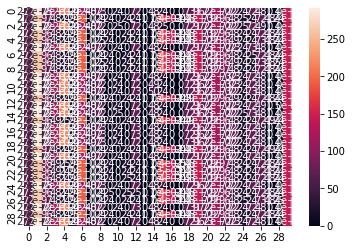

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
# plot_confusion_matrix(text_clf, y_train, predicted)

In [ ]:
roc_auc_score(y_train, text_clf.predict_proba(X_train), multi_class='ovr')

1.0

## Amalgamated the Fox News to Political and perform Predictions

Data Narrative :

Accuracy Score = 100%, F1 score = 1.

In [ ]:
date_politifact = data_politifact['date']
statement_politifact = data_politifact['statement']
date_foxnews = data_foxnews['date']
headline_foxnews = data_foxnews['headline']

In [ ]:
date = [date_politifact, date_foxnews]

In [ ]:
date = date_politifact.append(date_foxnews)

In [ ]:
text = [statement_politifact, headline_foxnews]

In [ ]:
text = statement_politifact.append(headline_foxnews)

In [ ]:
combined_Data = pd.concat([date, text], axis=1)

In [ ]:
combined_Data.head(2)

,date,0
0,"March 30, 2021",“Less than 500 people a year killed by all rif...
1,"March 30, 2021",Says the suspected Boulder mass shooter is a M...


In [ ]:
combined_Data.columns =['date', 'text']

In [ ]:
combined_Data.head(2)

,date,text
0,"March 30, 2021",“Less than 500 people a year killed by all rif...
1,"March 30, 2021",Says the suspected Boulder mass shooter is a M...


In [ ]:
combined_Data.describe()

,date,text
count,391970,391970
unique,16,159
top,2021-04-18,Minnesota armed carjacker points gun at vehicl...
freq,190000,6000


In [ ]:
combined_Data

,date,text
0,"March 30, 2021",“Less than 500 people a year killed by all rif...
1,"March 30, 2021",Says the suspected Boulder mass shooter is a M...
2,"March 30, 2021",“Toxicology report was made public by the MN p...
3,"March 30, 2021","Says Jimmy Kimmel, Jimmy Fallon and Stephen Co..."
4,"March 29, 2021",Says Google Earth blocked people from seeing t...
...,...,...
331995,2021-04-18,Minnesota armed carjacker points gun at vehicl...
331996,2021-04-18,Houston police say crystal meth found in break...
331997,2021-04-18,Minneapolis drive-by shooting leaves 2 Nationa...
331998,2021-04-18,Man charged with attacking undercover NYPD cop...


### Amalgamated Training Pipeline Politifact with Test Prediction Fox News

Data Narrative : 

Accuracy score = 3%.

F1 score for each trained text samples range from 1% to 7% score.

In [ ]:
from sklearn.model_selection import train_test_split
X = combined_Data['text']
y = combined_Data['text']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt  
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [ ]:
text_clf.fit(X_train, y_train )

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
from sklearn import metrics
text_clf.fit(list(X_train), list(y_train))

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [ ]:
predicted = text_clf.predict(list(y_test))
predicted

array(['"We began seeing the increase in unaccompanied minors going back to last April 2020. This is not something that happened as a result of Joe Biden becoming president.”',
       'Garden gnome shortage strikes due to pandemic and Suez Canal blockage',
       '“We spent billions on a border wall and quit when it was 90% finished.”',
       ..., 'New York coronavirus restrictions keeping dojo shuttered',
       'Kamala Harris has gone 25 days without a news conference since being tapped for border crisis role',
       "McDonald's worker puts up sign in drive-thru to explain their slow service"],
      dtype='<U221')

In [ ]:
print(metrics.classification_report(list(y_test), predicted))

                                                                                                                                                                                                                               precision    recall  f1-score   support

"In 2004, George W. Bush lifted the ban on those (AR-15 type) rifles, and since then, the number of massacres has increased 183%. During the ban, there were 12 incidents. Since he lifted the ban, there were 34 incidents."       1.00      1.00      1.00       378
                            "Joe Biden forced the U.S. Attorney for the Eastern District of North Carolina to resign after 24 people were charged with election fraud and the Mainstream Media never even batted an eyelash."       1.00      1.00      1.00       379
                "Since 2006 Texas has given $19B in taxpayer subsidies to wind energy companies. Over the past 2-3 years Texas has tripled our dependence on wind energy to 23-25 percent of our energy distributi

In [ ]:
cf_matrix = confusion_matrix(y_test, predicted)

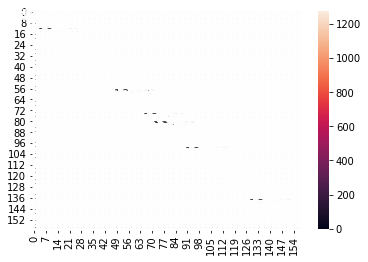

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
# plot_confusion_matrix(text_clf, y_train, predicted)

In [ ]:
roc_auc_score(y_train, text_clf.predict_proba(X_train), multi_class='ovr')

1.0